In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from urllib.request import urlopen
import webbrowser
import requests
import lxml.html
import re
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import font_manager
%matplotlib inline
import urllib.parse
import seaborn as sns

MARKET_CODE_DICT = {
    'kospi': 'stockMkt',
    'kosdaq': 'kosdaqMkt',
    'konex': 'konexMkt'
}
DOWNLOAD_URL = 'kind.krx.co.kr/corpgeneral/corpList.do'
def download_stock_codes(market=None, delisted=False):
    params = {'method': 'download'}

    if market.lower() in MARKET_CODE_DICT:
        params['marketType'] = MARKET_CODE_DICT[market]

    if not delisted:
        params['searchType'] = 13

    params_string = urllib.parse.urlencode(params)
    request_url = urllib.parse.urlunsplit(['http', DOWNLOAD_URL, '', params_string, ''])

    df = pd.read_html(request_url, header=0)[0]
    df.종목코드 = df.종목코드.map('{:06d}'.format)

    return df
kosdaq_stocks = download_stock_codes('kospi')

In [2]:
stock = input("찾으시는 주식이름을 입력해주세요")

찾으시는 주식이름을 입력해주세요삼성전자


In [3]:
startData = input("시작 날짜를 입력해주세요")

시작 날짜를 입력해주세요20150101


In [4]:
columName = str(input("보고싶은 것?"))

보고싶은 것?매출액


In [5]:
stock_codeDF = kosdaq_stocks[(kosdaq_stocks.회사명 == stock)][['회사명','종목코드']]

stock_code = stock_codeDF.iloc[0]['종목코드']
stock_name = stock_codeDF.iloc[0]['회사명']

authKey = "92514dfc41e26715c7159127608020b866378caf"
companyCode = stock_code
startDate = startData

url = "http://dart.fss.or.kr/api/search.xml?auth="+authKey+"&crp_cd="+companyCode+"&start_dt="+startDate+"&bsn_tp=A001"+"&page_set=100"

resultXML = urlopen(url)
result = resultXML.read()

xmlsoup = BeautifulSoup(result , 'html.parser')

data = pd.DataFrame()
te = xmlsoup.findAll("list")

for i in te:
    temp = pd.DataFrame(([[i.crp_cls.string,i.crp_nm.string,i.crp_cd.string,i.rpt_nm.string,i.rcp_no.string,
                          i.flr_nm.string,i.rcp_dt.string,i.rmk.string]]),
                       columns = ["crp_cls","crp_nm","crp_cd","rpt_nm","rcp_no","flr_nm","rcp_dt","rmk"])
    data = pd.concat([data,temp])

data = data.reset_index(drop=True)
data

,crp_cls,crp_nm,crp_cd,rpt_nm,rcp_no,flr_nm,rcp_dt,rmk
0,Y,삼성전자,005930,사업보고서 (2018.12),20190401004781,삼성전자,20190401,연
1,Y,삼성전자,005930,사업보고서 (2017.12),20180402005019,삼성전자,20180402,연
2,Y,삼성전자,005930,사업보고서 (2016.12),20170331004518,삼성전자,20170331,연
3,Y,삼성전자,005930,사업보고서 (2015.12),20160330003536,삼성전자,20160330,연
4,Y,삼성전자,005930,사업보고서 (2014.12),20150331002915,삼성전자,20150331,연


In [6]:
data.rpt_nm[1].strip("사업보고서 ")

'(2017.12)'

In [7]:
rcpNoList = data["rcp_no"].tolist()
rptNmList = data["rpt_nm"].tolist()
tempList = []
realList = []
tempIndex = 0
for i in range(0,len(rcpNoList)):
    url_user = "http://dart.fss.or.kr/dsaf001/main.do?rcpNo="+rcpNoList[i]
    req = requests.get(url_user)
    tree = lxml.html.fromstring(req.text)
    onclick = tree.xpath('//*[@id="north"]/div[2]/ul/li[1]/a')[0].attrib['onclick']
    pattern = re.compile("^openPdfDownload\('\d+',\s*'(\d+)'\)")
    dcm_no = pattern.search(onclick).group(1)
    
    resp = "http://dart.fss.or.kr/report/viewer.do?rcpNo="+rcpNoList[i]+"&dcmNo="+dcm_no+"&eleId=11&offset=603619&length=1499098&dtd=dart3.xsd"

    report = urlopen(resp)
    tempload = report.read()
  
    parsing = BeautifulSoup(tempload,'html.parser') 
    body = parsing.find("body")

    table = body.find_all("tbody")
    
    if(len(table) < 2):
        continue
    
    tmp2 = table[1]    

    tr = tmp2.select('tr')
    td = tmp2.select('tr > td')
    cellCount = int(len(td)/len(tr))
    
    for j in range(1,len(td)):
        if(j % cellCount == 0 ):
            tempA = (str(td[j]).split('>')[1].split('<')[0].replace("\xa0","").strip()) # .replace("           ",""))
            
            ##정규표현식으로 해당 단어 있을 시 찾는걸로 change
            if(tempA == columName):
                tempIndex = j + 1
                tempList.append(str(td[tempIndex]).split('>')[1].split('<')[0])
                realList.append(rcpNoList[i])
                break;
    else:
        print(rptNmList[i]+" 문서에는 찾으시는 자료가 없습니다.")
    
#     date = (str(td[tempIndex-cellCount]).split('>')[1].split('<')[0])   

tempDataFrame = pd.DataFrame(tempList, columns = [columName])

for i in range(0,len(realList)):
    realList[i] = realList[i][0:4]

tempDataFrame2 = pd.DataFrame(realList, columns = ["년도"])


resultDataFrame = pd.concat([tempDataFrame2,tempDataFrame], axis = 1)
# resultDataFrame = resultDataFrame.sort_values(by = ["년도"],ascending = True)
# resultDataFrame.reset_index()

fontprop = font_manager.FontProperties(fname="c:/windows/Fonts/malgun.ttf").get_name()
matplotlib.rc('font', family=fontprop)

In [8]:
x = list(resultDataFrame["년도"])
y = list(resultDataFrame[columName])
print(x)
print(y)
resultDataFrame

['2019', '2018', '2017', '2016', '2015']
['243,771,415', '239,575,376', '201,866,745', '200,653,482', '206,205,987']


,년도,매출액
0,2019,"243,771,415"
1,2018,"239,575,376"
2,2017,"201,866,745"
3,2016,"200,653,482"
4,2015,"206,205,987"


In [10]:
resultDataFrame["매출액"] = resultDataFrame["매출액"].str.replace(',','')

resultDataFrame["년도"] = resultDataFrame.년도.astype(int)
def columnType(incol):
    outcol = incol.replace(" ","")
    return outcol

resultDataFrame["매출액"] = resultDataFrame["매출액"].apply(columnType)
resultDataFrame["매출액"] =resultDataFrame["매출액"].astype(int)
resultDataFrame.sort_values(by='년도',ascending=True)

,년도,매출액
0,2019,243771415
1,2018,239575376
2,2017,201866745
3,2016,200653482
4,2015,206205987


Text(0,0.5,'매출액')

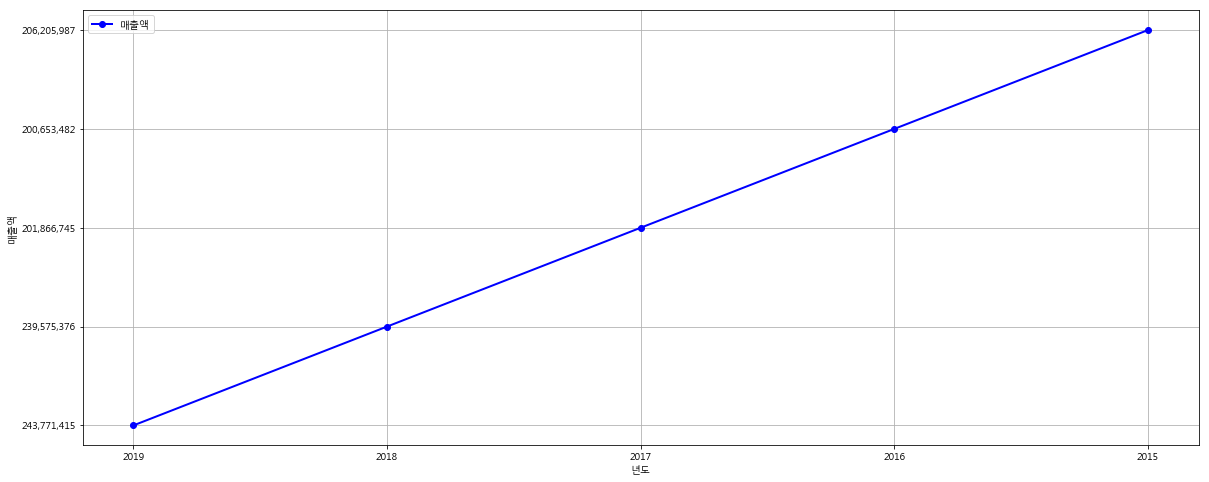

In [12]:
fig = plt.figure(figsize=(20,8))
# plt.plot(x,y)
plt.plot(x,y, 'bo-', lw=2, label = columName)
plt.legend(loc=0)
plt.grid(True)
plt.xlabel("년도")
plt.ylabel(columName)

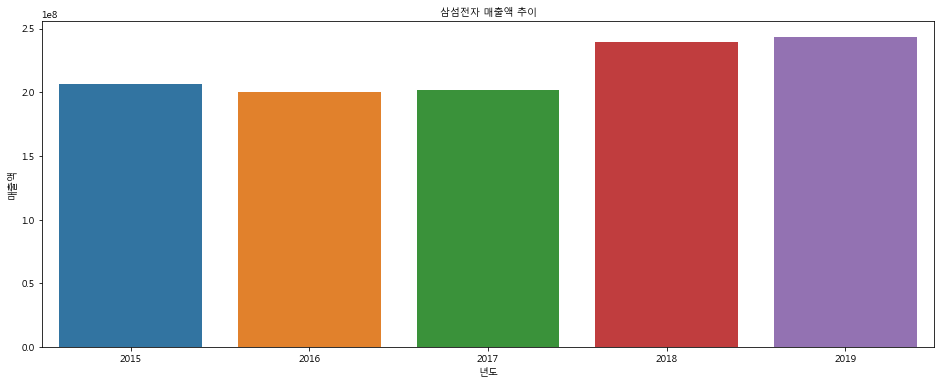

In [22]:
plt.figure(figsize=(16,6))
sns.barplot(x='년도',y='매출액',data=resultDataFrame)
plt.title('삼섬전자 매출액 추이',fontsize='10')
plt.show()

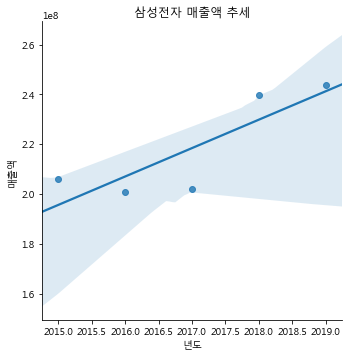

In [33]:
sns.lmplot(x='년도',y='매출액',data=resultDataFrame)
plt.title('삼성전자 매출액 추세')
plt.show()